## Exploration of Various ML Models & Techniques for Predictive Modelling of Mortality & ICU Stay (24H)

Attempt to model impact of selected RISK FACTORS on "risk" outcomes: 'ICUAdmgt24h', 'thirtydaymortality', 'Mortality'
- Create a NEW target variable 'ICUMortalityrisk_ind' to model either 24H ICU or 30-day mortality risk
- DROP 'Mortality' variable

In [12]:
# import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import warnings

In [3]:
# Import dataset & generate combined  'ICUAdmgt24h', 'thirtydaymortality' variable 
data = pd.read_csv('../data/CARES_data_predictionv1.csv')
# data = data.drop('Mortality', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69667 entries, 0 to 69666
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GENDER                             69667 non-null  object 
 1   Anemia category                    69667 non-null  object 
 2   Preoptransfusionwithin30days       69667 non-null  float64
 3   Intraop                            69667 non-null  float64
 4   Transfusionintraandpostop          69667 non-null  float64
 5   AnaestypeCategory                  69667 non-null  object 
 6   PriorityCategory                   69667 non-null  object 
 7   TransfusionIntraandpostopCategory  69667 non-null  object 
 8   AGEcategory                        69667 non-null  object 
 9   SurgRiskCategory                   69667 non-null  object 
 10  GradeofKidneyCategory              69667 non-null  object 
 11  RDW15.7                            69667 non-null  obj

In [4]:
data['ICUAdmgt24h'].value_counts(normalize=True)

ICUAdmgt24h
0    0.98322
1    0.01678
Name: proportion, dtype: float64

In [5]:
data['thirtydaymortality'].value_counts(normalize=True)

thirtydaymortality
False    0.992479
True     0.007521
Name: proportion, dtype: float64

In [6]:
data['Mortality'].value_counts(normalize=True)

Mortality
No death    0.92335
Yes         0.07665
Name: proportion, dtype: float64

### Create "Combined" Surgery Risk Indicator
- Either ICU Admission (24H) OR Thirty-Day Mortality
- *Can consider combining all 3 target variables including 'Mortality after surgery'*
- Option (1) was applied!

In [7]:
# create new variable ('ICUMortalityrisk_ind')
data['ICUMortalityrisk_ind'] = ((data['ICUAdmgt24h'] == 1) | (data['thirtydaymortality'] == True) | (data['Mortality'] == 'Yes')).astype(int)
data['ICUMortalityrisk_ind'].value_counts(normalize=True)

ICUMortalityrisk_ind
0    0.913101
1    0.086899
Name: proportion, dtype: float64

In [8]:
# drop other target variables
data = data.drop(['ICUAdmgt24h', 'thirtydaymortality', 'Mortality'], axis=1)

## Severe Class Imbalance - Review possible Approaches
**Medium Article:** https://medium.com/@narenderbeniwal1234/how-to-deal-with-imbalanced-data-9b7b0bd2f44f
- Balance classes by re-sampling with SMOTE (Not reccommended as class imbalance is 1:50)
- Adjust class weights to give a higher penalty for mis-classifying the minority class
- Use Tree-based Ensemble models (less sensitive to class imbalance)
- Adjust Evaluation Metrics(Precision, Recall:Impt, F1-score, ROCAUC curve, precision recall curve, precision-recall trade-off curve)
- Optimize classification threshold (eg. 0.3 for positive class bias etc.)

In [9]:
# Define categorical, numeric & target columns
# Define the target columns
# target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'ICUMortalityrisk_ind']
target_var = 'ICUMortalityrisk_ind'
target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'Mortality', 'ICUMortalityrisk_ind']

# Select categorical columns and exclude target columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
cat_cols = [col for col in cat_cols if col not in target_cols]

# Select numerical columns and exclude target columns
num_cols = data.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col not in target_cols]

In [10]:
cat_cols

['GENDER',
 'Anemia category',
 'AnaestypeCategory',
 'PriorityCategory',
 'TransfusionIntraandpostopCategory',
 'AGEcategory',
 'SurgRiskCategory',
 'GradeofKidneyCategory',
 'RDW15.7',
 'ASAcategorybinned']

In [11]:
num_cols

['Preoptransfusionwithin30days', 'Intraop', 'Transfusionintraandpostop']

### Parameters for Predictive Modelling Framework
- Test models which are more suited for (1) Categorical Variables & (2) Class Imbalance
1. Logistic Regression (with oversampling)
2. Random Forest Ensemble ****Balance by adding class weights***
3. Gradient Boosting
4. XGBoost (optimized?) - Should give the best results
- **Hyperparameter tuning:** All normal hyperparameters, classification threshold*
- **Evaluation:** Precision, Recall:Impt, F1-score, ROCAUC curve, precision recall curve, precision-recall trade-off curve (for threshold selection)

In [11]:
# Tackling class imbalance through over-sampling might lead to overfitting as synthetic records are used to 
# balance the minority class. Model might not be able to generalize well to real-world use cases. 

In [15]:
def model_evaluation(data, cat_cols, num_cols, target_col, threshold=0.5):
    # Separate features and target
    X = data[cat_cols + num_cols]
    y = data[target_col]

    # One hot encoding for categorical variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply preprocessor to training and test data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    # Oversample the minority class
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Models and their hyperparameter grids for RandomizedSearchCV
    models = {
        'Logistic Regression': (LogisticRegression(max_iter=1000), {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }),
        'Random Forest': (RandomForestClassifier(), {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }),
        'Gradient Boosting': (GradientBoostingClassifier(), {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }),
        'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        })
    }

    for model_name, (model, params) in models.items():
        # Randomized search for hyperparameter tuning
        search = RandomizedSearchCV(model, params, n_iter=10, scoring='roc_auc', cv=5, verbose=1, random_state=42, n_jobs=-1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        # Predict probabilities and apply threshold
        y_prob = best_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        # Evaluation metrics
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_prob)
        
        print(f"Model: {model_name}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("")

        # ROC AUC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(10, 5))
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(10, 5))
        plt.plot(recall_curve, precision_curve, label=f'{model_name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel

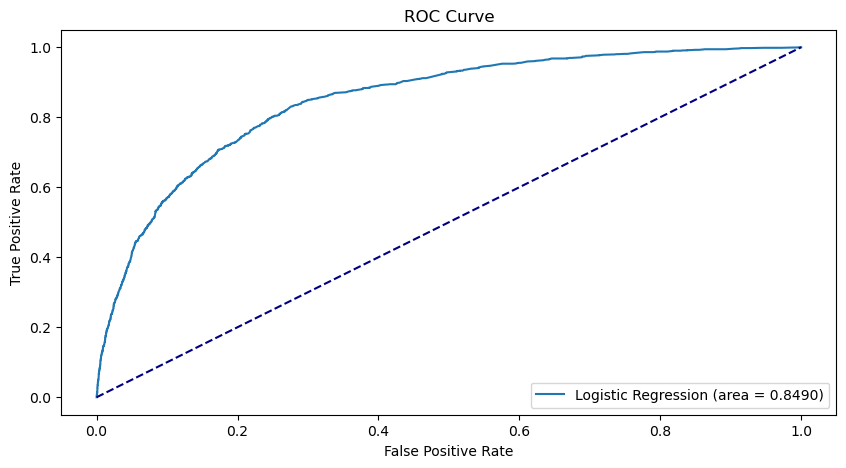

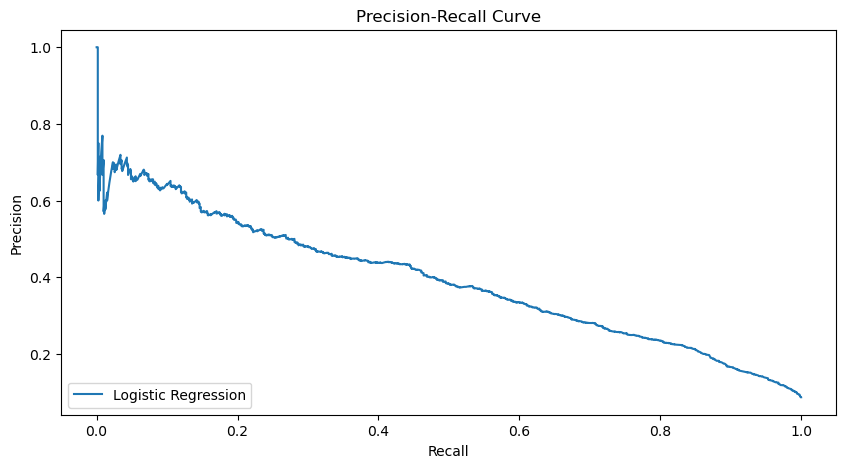

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model: Random Forest
Precision: 0.2874
Recall: 0.4203
F1-score: 0.3414
ROC AUC: 0.7602



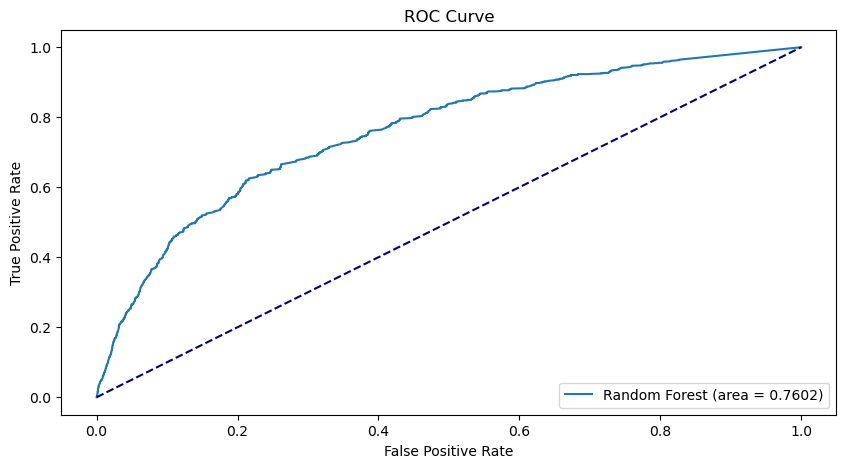

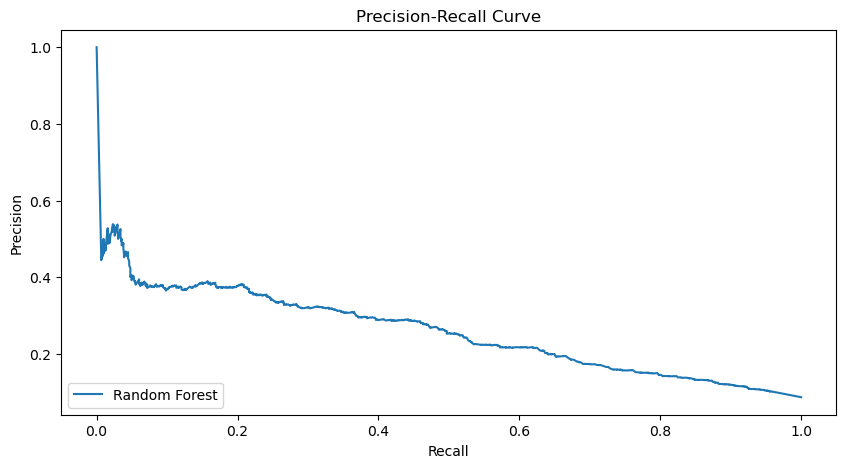

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model: Gradient Boosting
Precision: 0.3184
Recall: 0.5169
F1-score: 0.3941
ROC AUC: 0.8233



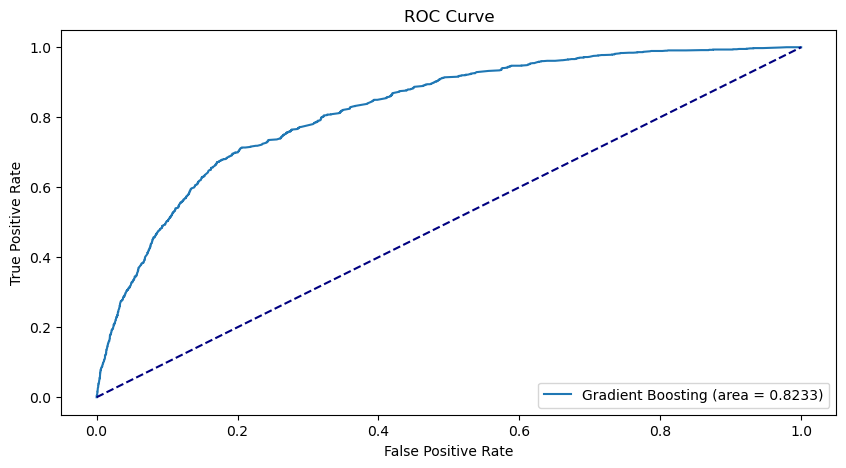

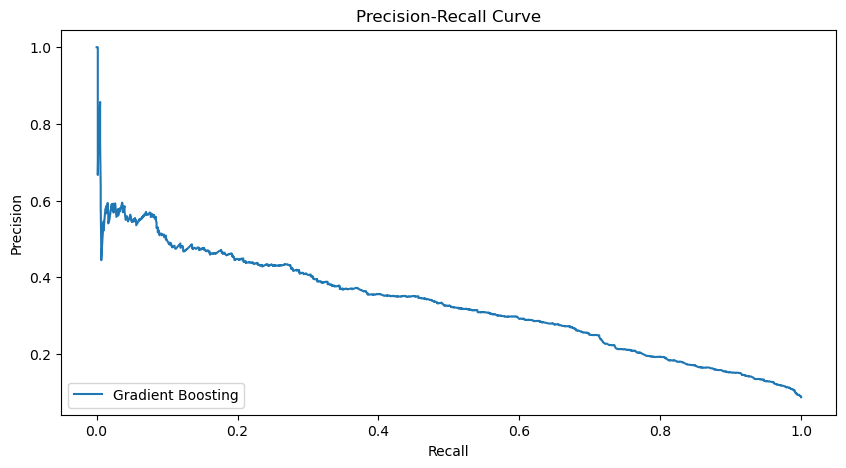

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spars

Model: XGBoost
Precision: 0.3200
Recall: 0.5202
F1-score: 0.3962
ROC AUC: 0.8265



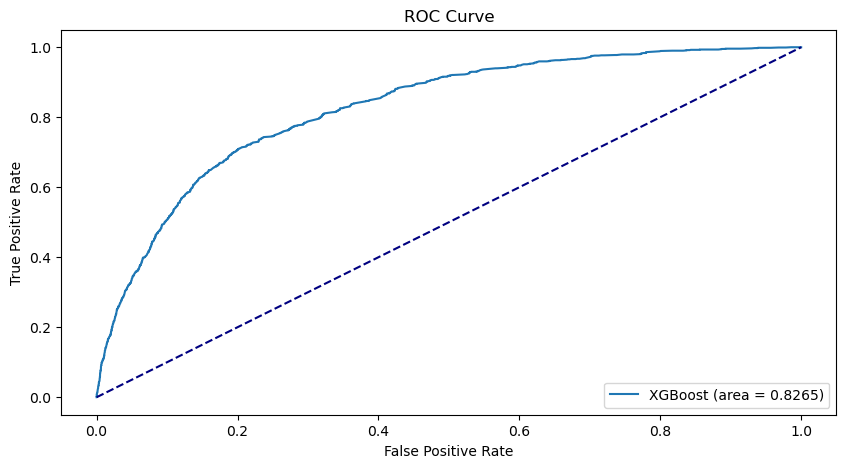

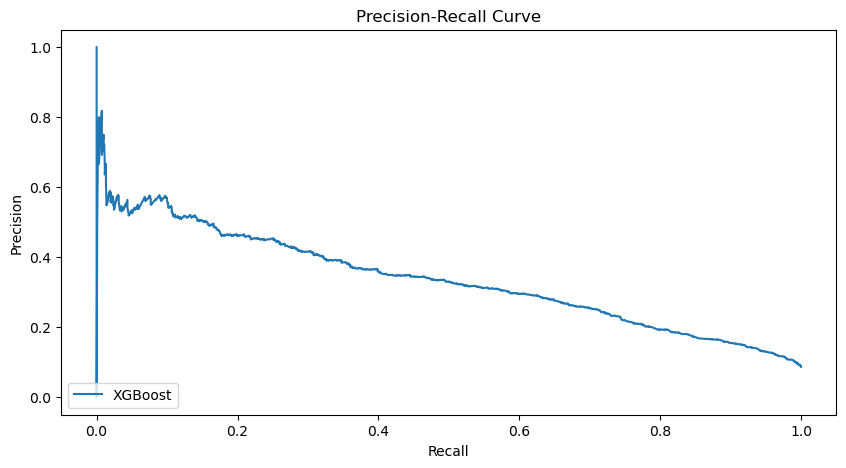

In [16]:
# Run models!
model_evaluation(data, cat_cols, num_cols, 'ICUMortalityrisk_ind')